In [10]:
#Import different libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle


In [11]:
#Import paths
BASE_PATH = "../"
DATA = os.path.join(BASE_PATH, "data")
DATA_TRAIN = os.path.join(DATA, "train")
DATA_VALIDATION = os.path.join(DATA, "validation")

In [12]:
#Parameters setup
img_height, img_width = 150, 150
batch_size = 32
epochs = 50

In [13]:
#Prepare generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  #20% for validation
)

train_generator = train_datagen.flow_from_directory(
    DATA_TRAIN,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  #80% for training
    classes=['covid', 'lung_opacity', 'normal', 'pneumonia', 'trash']
)

validation_generator = train_datagen.flow_from_directory(
    DATA_TRAIN,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  #20% for validation
    classes=['covid', 'lung_opacity', 'normal', 'pneumonia', 'trash']
)

#Show classes
print("Classes trouvées :", train_generator.class_indices)

#Show number of images for training and validation
print(f"image for training: {train_generator.samples}")
print(f"image for validation: {validation_generator.samples}")

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.
Classes trouvées : {'covid': 0, 'lung_opacity': 1, 'normal': 2, 'pneumonia': 3}
image for training: 16933
image for validation: 4232


In [14]:
#Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

c:\Users\Raph\miniconda3\envs\pulmoScan4\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
#Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('models/best_model.keras', save_best_only=True)
]

In [17]:
#Train model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 179s 334ms/step - accuracy: 0.5829 - loss: 0.9786 - val_accuracy: 0.7328 - val_loss: 0.6699
Epoch 2/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 161s 303ms/step - accuracy: 0.7151 - loss: 0.7125 - val_accuracy: 0.7651 - val_loss: 0.6059
Epoch 3/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 161s 301ms/step - accuracy: 0.7632 - loss: 0.6028 - val_accuracy: 0.8025 - val_loss: 0.5231
Epoch 4/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 161s 303ms/step - accuracy: 0.7910 - loss: 0.5354 - val_accuracy: 0.8181 - val_loss: 0.4729
Epoch 5/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 163s 307ms/step - accuracy: 0.8156 - loss: 0.4769 - val_accuracy: 0.8459 - val_loss: 0.4209
Epoch 6/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 161s 302ms/step - accuracy: 0.8380 - loss: 0.4261 - val_accuracy: 0.8540 - val_loss: 0.3970
Epoch 7/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 162s 305ms/step - accuracy: 0.8501 - loss: 0.4015 - val_accuracy: 0.8568 - val_loss: 0.3757
Epoch 8/50
530/530 ━━━━━━━━━━━━━━━━━━━━ 164s 307ms/step - accuracy: 0.8547 -

In [18]:

#Evaluate model
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {accuracy * 100:.2f}%")

133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - accuracy: 0.8977 - loss: 0.2636
Validation accuracy: 89.37%


In [19]:
#Save model
model.save('models/cnn_model.h5')

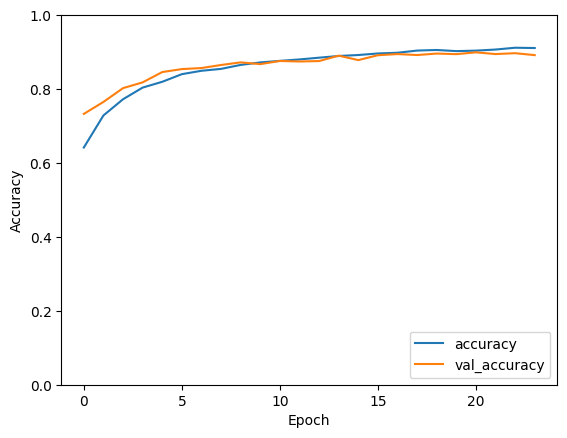

In [21]:
#Convert to piclke
with open('models/cnn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Visualiser les courbes d'entraînement
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()